In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## 0. Load Data

In [3]:
data = pd.read_csv('../data/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


## 1. Data Analysis: First Sight

### How is the date distribuited?

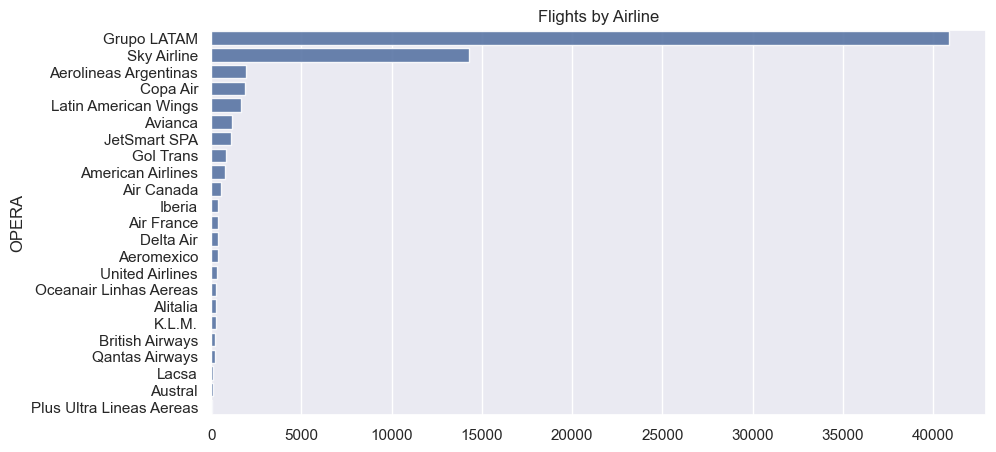

In [24]:
flights_by_airline = data['OPERA'].value_counts()
plt.figure(figsize = (10, 5))
sns.barplot(y=flights_by_airline.index, x=flights_by_airline.values, alpha=0.9)
plt.title('Flights by Airline')
plt.show()

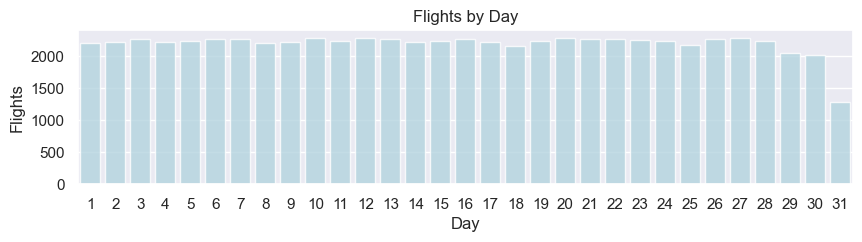

In [30]:
flights_by_day = data['DIA'].value_counts()
plt.figure(figsize = (10, 2))
sns.barplot(x=flights_by_day.index, y=flights_by_day.values, color = 'lightblue', alpha=0.8)
plt.title('Flights by Day')
plt.ylabel('Flights')
plt.xlabel('Day')
plt.show()

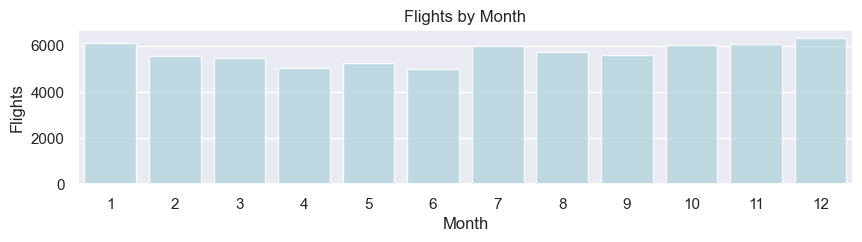

In [35]:
flights_by_month = data['MES'].value_counts()
plt.figure(figsize = (10, 2))
sns.barplot(x=flights_by_month.index, y=flights_by_month.values, color = 'lightblue', alpha=0.8)
plt.title('Flights by Month')
plt.ylabel('Flights',)
plt.xlabel('Month')
plt.show()

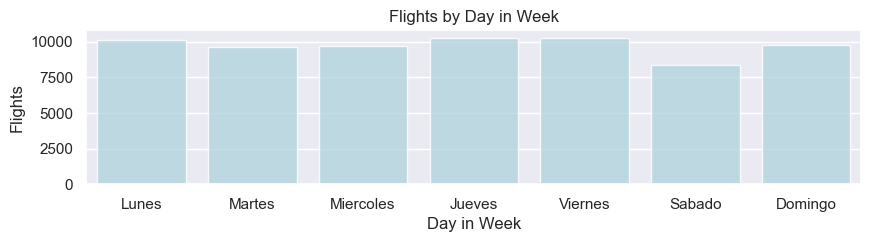

In [39]:
flights_by_day_in_week = data['DIANOM'].value_counts()
days = [
    flights_by_day_in_week.index[2], 
    flights_by_day_in_week.index[5], 
    flights_by_day_in_week.index[4], 
    flights_by_day_in_week.index[1], 
    flights_by_day_in_week.index[0], 
    flights_by_day_in_week.index[6], 
    flights_by_day_in_week.index[3]
]
values_by_day = [
    flights_by_day_in_week.values[2], 
    flights_by_day_in_week.values[5], 
    flights_by_day_in_week.values[4], 
    flights_by_day_in_week.values[1], 
    flights_by_day_in_week.values[0], 
    flights_by_day_in_week.values[6], 
    flights_by_day_in_week.values[3]
]
plt.figure(figsize = (10, 2))
sns.set(style="darkgrid")
sns.barplot(x=days, y=values_by_day, color = 'lightblue', alpha=0.8)
plt.title('Flights by Day in Week')
plt.ylabel('Flights')
plt.xlabel('Day in Week')
plt.show()

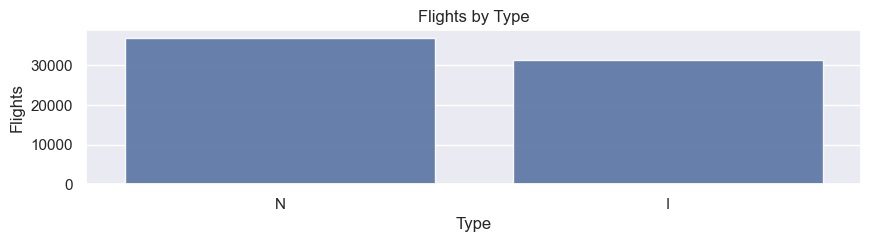

In [43]:
flights_by_type = data['TIPOVUELO'].value_counts()
sns.set(style="darkgrid")
plt.figure(figsize = (10, 2))
sns.barplot(x=flights_by_type.index, y=flights_by_type.values, alpha=0.9)
plt.title('Flights by Type')
plt.ylabel('Flights')
plt.xlabel('Type')
plt.show()

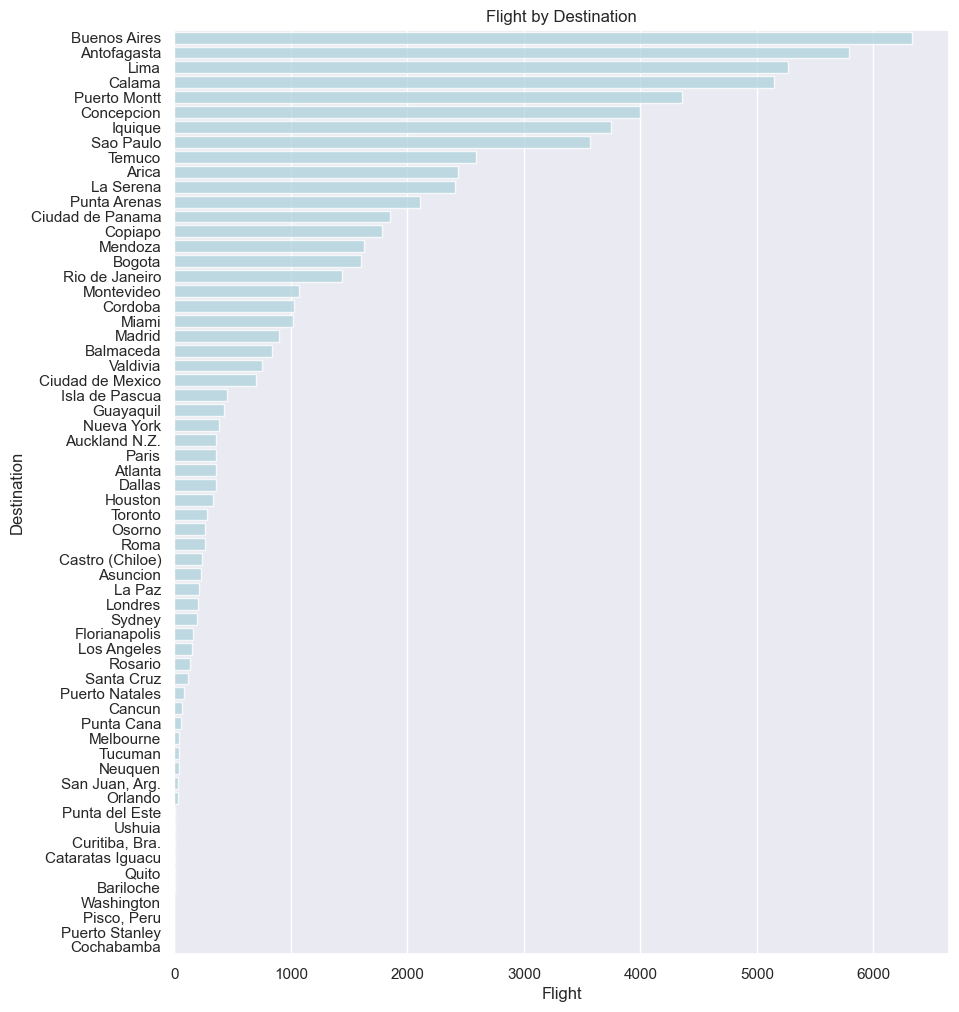

In [53]:
flight_by_destination = data['SIGLADES'].value_counts()
plt.figure(figsize = (10, 12))
sns.set(style="darkgrid")
sns.barplot(y=flight_by_destination.index, x=flight_by_destination.values, color = 'lightblue', alpha=0.8)
plt.title('Flight by Destination')
plt.ylabel('Destination')
plt.xlabel('Flight')
plt.show()

## 2. Features Generation

### 2.a. Period of Day

In [54]:
from datetime import datetime

def get_period_day(date):
    """
    Determina el período del día basado en la hora.
    
    Períodos:
    - morning: 5:00 - 11:59
    - afternoon: 12:00 - 18:59  
    - night: 19:00 - 4:59 (incluye madrugada del día siguiente)
    
    Args:
        fecha: pandas Series con fechas y horas
    
    Returns:
        pandas Series con 'morning', 'afternoon', 'night'
    """
    dates = pd.to_datetime(date)
    
    # Extraer la hora (0-23)
    hour = dates.dt.hour

    # Crear condiciones para cada período
    morning_mask = (hour >= 5) & (hour <= 11)
    afternoon_mask = (hour >= 12) & (hour <= 18)
    night_mask = (hour >= 19) | (hour <= 4)

    # FORMA PROFESIONAL 1: Usar np.select (MÁS COMÚN Y ELEGANTE)
    conditions = [morning_mask, afternoon_mask, night_mask]
    choices = ['morning', 'afternoon', 'night']
    
    return np.select(conditions, choices, default='unknown')

In [57]:
data['period_day'] = get_period_day(data['Fecha-I'])
data['period_day'].value_counts()

period_day
afternoon    25506
morning      25352
night        17348
Name: count, dtype: int64

### 2.b. High Season

In [58]:
from datetime import datetime

def is_high_season(fecha: str)->int:
    """
    Determina si una fecha está en temporada alta.
    
    Temporada alta:
    - 15 de diciembre al 31 de diciembre
    - 1 de Enero al 3 Marzo
    - 15 de julio al 31 de julio  
    - 11 de septiembre al 30 de septiembre
    
    Args:
        date_series: pandas Series con fechas (puede ser string o datetime)
    
    Returns:
        pandas Series con 1 para temporada alta, 0 para temporada baja
    """
    # Convertir a datetime si no lo está ya
    dates = pd.to_datetime(fecha, errors='coerce')
        
    # Extraer mes y día
    month = dates.dt.month
    day = dates.dt.day
    
    # Definir condiciones para cada período de temporada alta
    december_high = ((month == 12) & (day >= 15) & (day <= 31))
    summer_high = ((month == 1) | (month == 2) | ((month == 3) & (day <= 3)))
    july_high = ((month == 7) & (day >= 15) & (day <= 31))
    september_high = ((month == 9) & (day >= 11) & (day <= 30))

    high_season = december_high | summer_high | july_high | september_high

    return high_season.astype(int)

In [59]:
data['high_season'] = is_high_season(data['Fecha-I'])
data['high_season'].value_counts()

high_season
0    45444
1    22762
Name: count, dtype: int64

### 2.c. Difference in Minutes

In [60]:
def get_min_diff(data):
    """
    Calculate the difference in minutes between two datetime columns in a
    DataFrame.

    Parameters
    ----------
    data : pd.DataFrame
        A DataFrame containing two columns:
        - 'Fecha-O': Date and time of flight operation, a datetime column or string in the
        format '%Y-%m-%d %H:%M:%S'
        - 'Fecha-I': Scheduled date and time of the flight, a datetime column or string in the
        format '%Y-%m-%d %H:%M:%S'

    Returns
    -------
    pd.Series
        A Series containing the difference in minutes between 'Fecha-O'
    and 'Fecha-I' for each row.
    """
    
    fecha_o = pd.to_datetime(data['Fecha-O'])
    fecha_i = pd.to_datetime(data['Fecha-I'])

    return (fecha_o - fecha_i).dt.total_seconds() / 60

In [61]:
data['min_diff']  = get_min_diff(data)
data['min_diff'].sum()

np.float64(621415.0)

### 2.d. Delay

In [64]:
threshold_in_minutes = 15
data['delay'] = np.where(data['min_diff'] > threshold_in_minutes, 1, 0)
data['delay'].value_counts()


delay
0    55592
1    12614
Name: count, dtype: int64

In [63]:
data.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'period_day', 'high_season',
       'min_diff', 'delay'],
      dtype='object')

## 3. Data Analysis: Second Sight

### How is the delay rate across columns?

In [104]:
def get_rate_from_column(data, column):
    """
    Computes the delay rate (%) grouped by the specified column.

    Args:
        data (pd.DataFrame): The dataset containing a 'delay' binary column (1 = delayed).
        column (str): The column to group by (e.g., 'OPERA', 'SIGLADES').

    Returns:
        pd.DataFrame: A DataFrame with delay rates (percentage) by category.
    """
    grouped = data.groupby(column)['delay']
    delay_rate = (grouped.sum() / grouped.count()) * 100
    
    return delay_rate.round(2).reset_index(name='Tasa (%)')

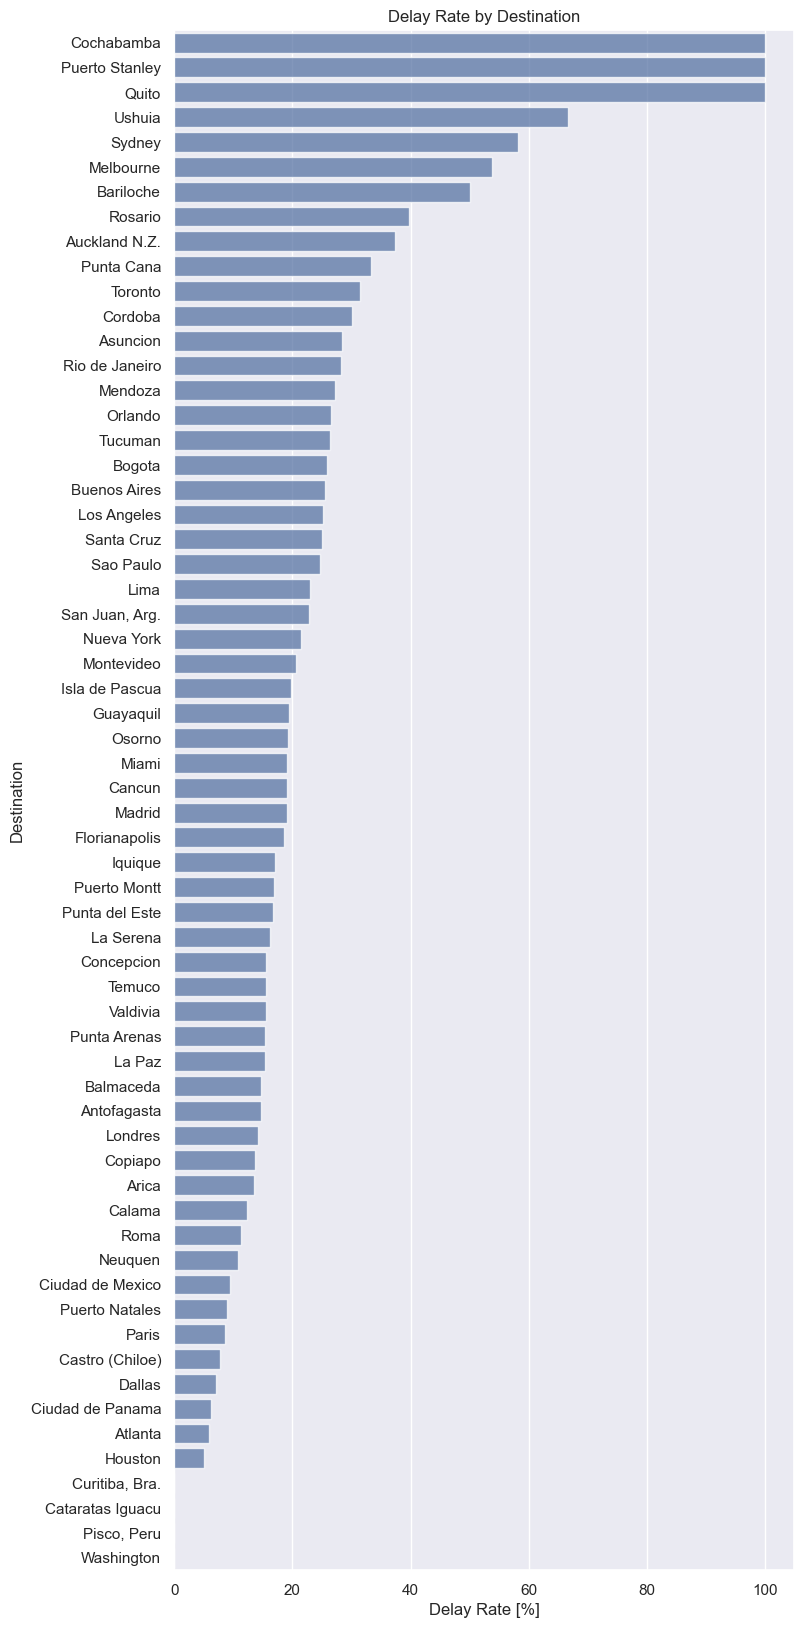

In [105]:
destination_rate = get_rate_from_column(data, 'SIGLADES')
destination_rate_values = destination_rate.sort_values(by='Tasa (%)', ascending=False)

plt.figure(figsize = (8,20))
sns.barplot(y=destination_rate_values['SIGLADES'], x=destination_rate_values['Tasa (%)'], alpha = 0.75)
plt.title('Delay Rate by Destination')
plt.ylabel('Destination')
plt.xlabel('Delay Rate [%]')
plt.show()

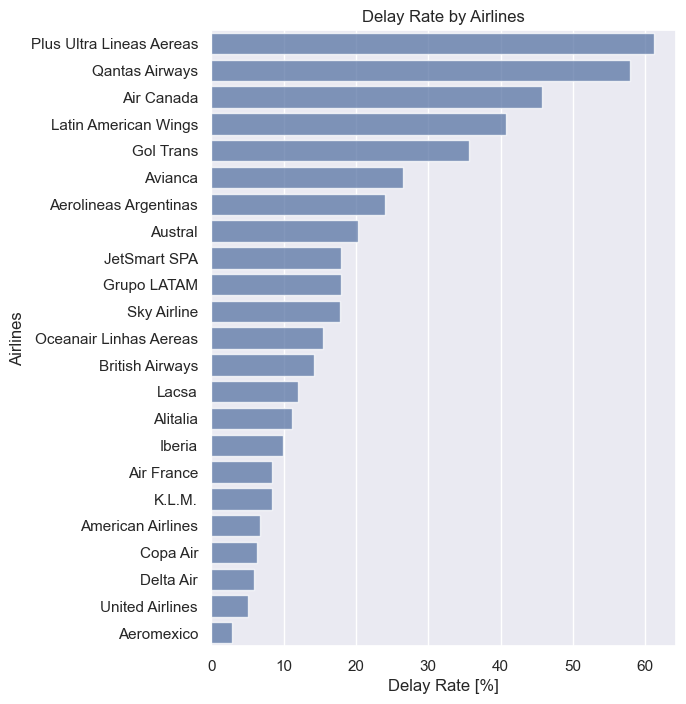

In [114]:
airlines_rate = get_rate_from_column(data, 'OPERA')
airlines_rate_values = airlines_rate.sort_values(by='Tasa (%)', ascending=False)

plt.figure(figsize = (6,8))
sns.barplot(y=airlines_rate_values['OPERA'], x=airlines_rate_values['Tasa (%)'], alpha = 0.75)
plt.title('Delay Rate by Airlines')
plt.ylabel('Airlines')
plt.xlabel('Delay Rate [%]')
plt.show()

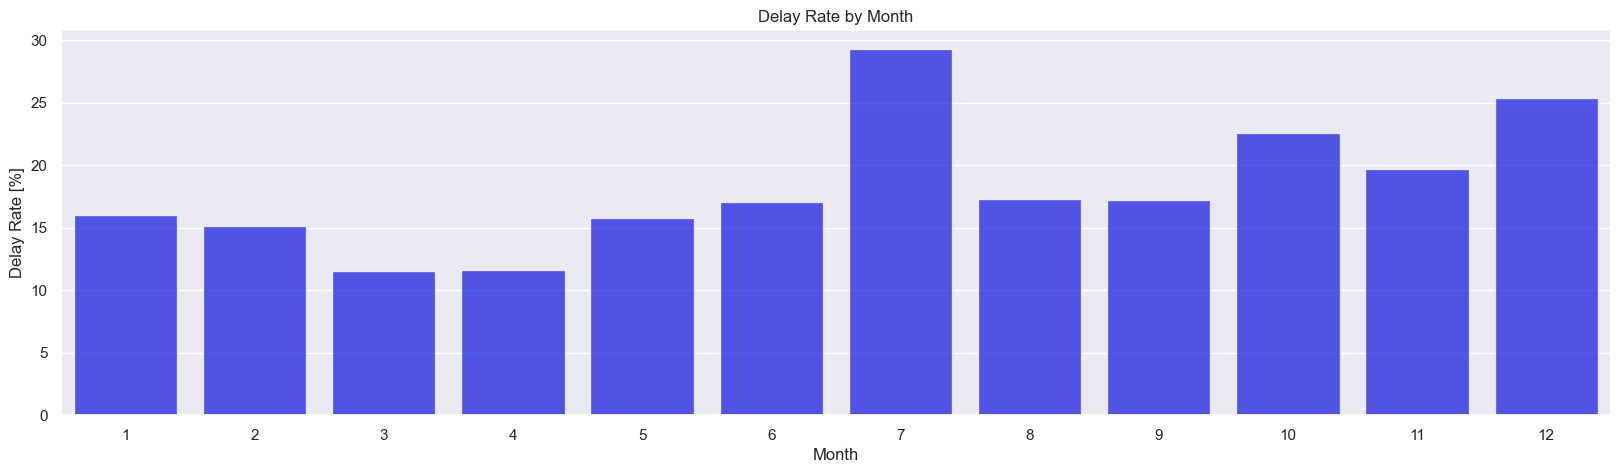

In [120]:
month_rate = get_rate_from_column(data, 'MES')
month_rate_value = month_rate.sort_values(by='Tasa (%)', ascending=False)

plt.figure(figsize = (20,5))
sns.barplot(x=month_rate_value['MES'], y=month_rate_value['Tasa (%)'], color = 'blue', alpha = 0.75)
plt.title('Delay Rate by Month')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Month')
plt.show()


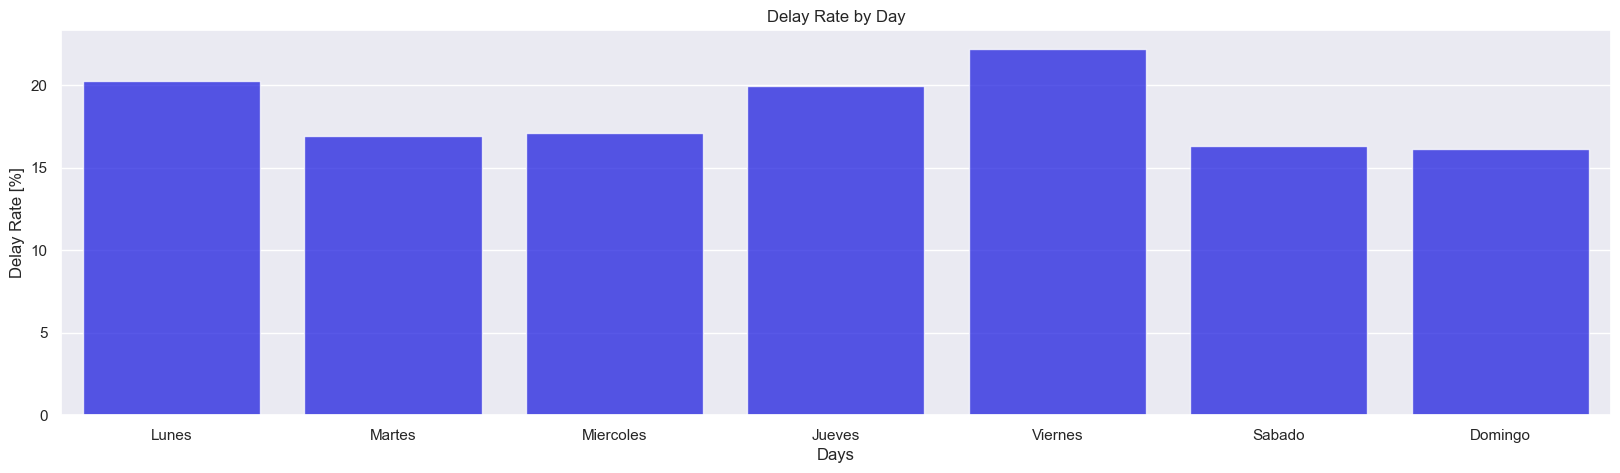

In [146]:
days_rate = get_rate_from_column(data, 'DIANOM')
days_sorted_list = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']

# Sort Dataframe by DAY
days_rate['DIANOM'] = pd.Categorical(days_rate['DIANOM'], categories=days_sorted_list, ordered=True)
days_rate_ordered = days_rate.sort_values('DIANOM')

# Reset Index
days_rate_ordered = days_rate_ordered.reset_index(drop=True)

plt.figure(figsize = (20, 5))
sns.barplot(x=days_rate_ordered['DIANOM'], y=days_rate_ordered['Tasa (%)'], color = 'blue', alpha = 0.75)
plt.title('Delay Rate by Day')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Days')
plt.show()

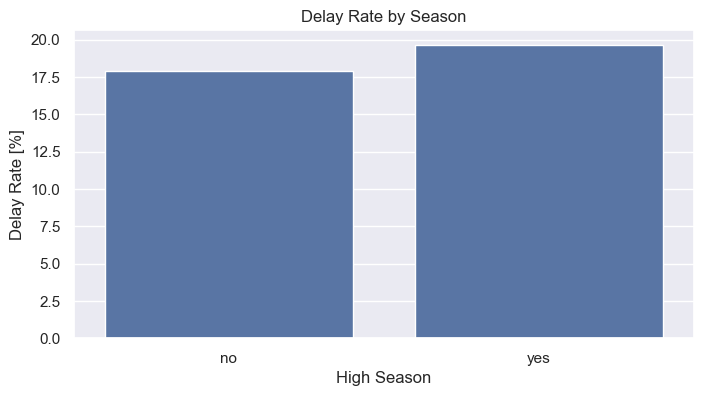

In [157]:
high_season_rate = get_rate_from_column(data, 'high_season')
high_season_rate_values = data['high_season'].value_counts().index

plt.figure(figsize = (8, 4))
sns.barplot(x=["no", "yes"], y=high_season_rate['Tasa (%)'])
plt.title('Delay Rate by Season')
plt.ylabel('Delay Rate [%]')
plt.xlabel('High Season')
plt.show()

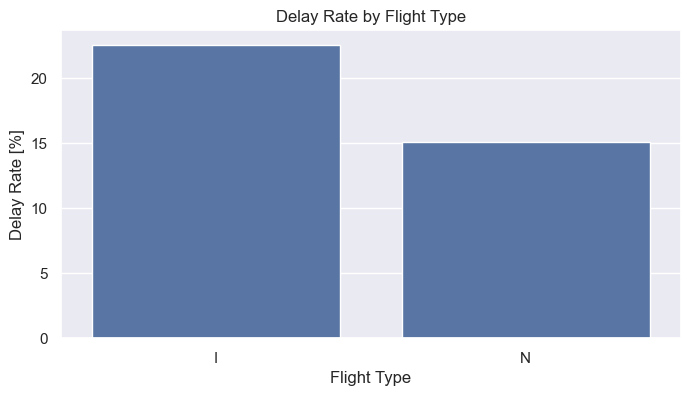

In [177]:
flight_type_rate = get_rate_from_column(data, 'TIPOVUELO')

plt.figure(figsize = (8, 4))
sns.barplot(x=flight_type_rate['TIPOVUELO'], y=flight_type_rate['Tasa (%)'])
plt.title('Delay Rate by Flight Type')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Flight Type')
plt.show()

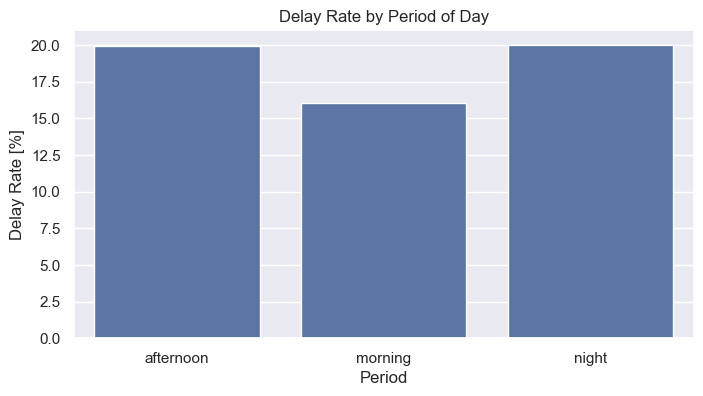

In [181]:
period_day_rate = get_rate_from_column(data, 'period_day')
period_day_rate_values = data['period_day'].value_counts().index

plt.figure(figsize = (8, 4))
sns.barplot(x=period_day_rate_values, y=period_day_rate['Tasa (%)'])
plt.title('Delay Rate by Period of Day')
plt.ylabel('Delay Rate [%]')
plt.xlabel('Period')
plt.show()

## 4. Training

### 4.a. Data Split (Training and Validation)

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report

In [191]:
training_data = shuffle(data[['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'delay']], random_state = 111)
training_data.head()

,OPERA,MES,TIPOVUELO,SIGLADES,DIANOM,delay
13375,Sky Airline,3,N,Antofagasta,Viernes,0
35799,Grupo LATAM,7,N,Concepcion,Jueves,0
48176,Grupo LATAM,9,N,Arica,Miercoles,0
58675,Grupo LATAM,11,N,Iquique,Viernes,0
23374,Sky Airline,5,N,Valdivia,Lunes,0


In [192]:
features = pd.concat([
    pd.get_dummies(data['OPERA'], prefix = 'OPERA'),
    pd.get_dummies(data['TIPOVUELO'], prefix = 'TIPOVUELO'), 
    pd.get_dummies(data['MES'], prefix = 'MES')], 
    axis = 1
)
target = data['delay']

In [190]:
features.head()

,OPERA_Aerolineas Argentinas,OPERA_Aeromexico,OPERA_Air Canada,OPERA_Air France,OPERA_Alitalia,OPERA_American Airlines,OPERA_Austral,OPERA_Avianca,OPERA_British Airways,OPERA_Copa Air,...,MES_3,MES_4,MES_5,MES_6,MES_7,MES_8,MES_9,MES_10,MES_11,MES_12
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [195]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.33, random_state = 42)

In [196]:
print(f"train shape: {x_train.shape} | test shape: {x_test.shape}")

train shape: (45698, 37) | test shape: (22508, 37)


In [197]:
y_train.value_counts('%')*100

delay
0    81.618452
1    18.381548
Name: proportion, dtype: float64

In [198]:
y_test.value_counts('%')*100

delay
0    81.277768
1    18.722232
Name: proportion, dtype: float64

### 4.b. Model Selection

#### 4.b.i. XGBoost

In [200]:
import xgboost as xgb
from xgboost import plot_importance

In [201]:
xgb_model = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
xgb_model.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [204]:
xgboost_y_preds = xgb_model.predict(x_test)
xgboost_y_preds = [1 if y_pred > 0.5 else 0 for y_pred in xgboost_y_preds]

In [205]:
confusion_matrix(y_test, xgboost_y_preds)

array([[18294,     0],
       [ 4214,     0]])

In [206]:
print(classification_report(y_test, xgboost_y_preds))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.00      0.00      0.00      4214

    accuracy                           0.81     22508
   macro avg       0.41      0.50      0.45     22508
weighted avg       0.66      0.81      0.73     22508



#### 4.b.ii. Logistic Regression

In [207]:
from sklearn.linear_model import LogisticRegression

In [208]:
reg_model = LogisticRegression()
reg_model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [209]:
reg_y_preds = reg_model.predict(x_test)

In [210]:
confusion_matrix(y_test, reg_y_preds)

array([[18193,   101],
       [ 4086,   128]])

In [211]:
print(classification_report(y_test, reg_y_preds))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90     18294
           1       0.56      0.03      0.06      4214

    accuracy                           0.81     22508
   macro avg       0.69      0.51      0.48     22508
weighted avg       0.77      0.81      0.74     22508



## 5. Data Analysis: Third Sight

### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

<Figure size 1000x500 with 0 Axes>

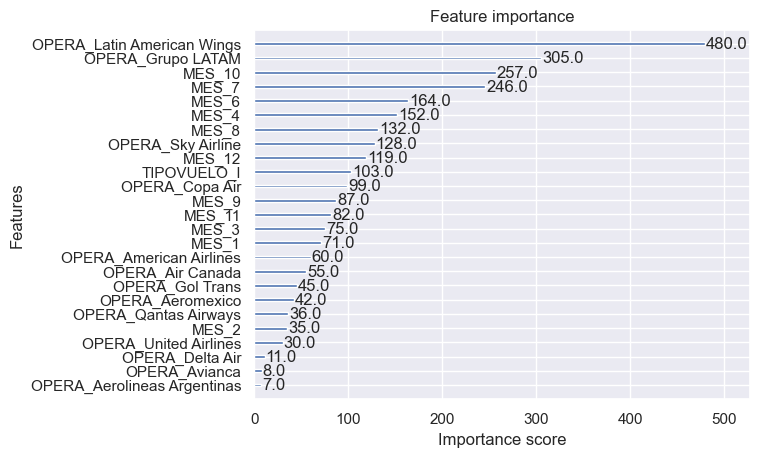

In [212]:
plt.figure(figsize = (10,5))
plot_importance(xgb_model)

In [213]:
top_10_features = [
    "OPERA_Latin American Wings", 
    "MES_7",
    "MES_10",
    "OPERA_Grupo LATAM",
    "MES_12",
    "TIPOVUELO_I",
    "MES_4",
    "MES_11",
    "OPERA_Sky Airline",
    "OPERA_Copa Air"
]

In [214]:
feature_importance = pd.DataFrame(xgb_model.feature_importances_, index=features.columns, columns=['Value']).sort_values(by='Value', ascending=False)
feature_importance.head(10)

,Value
TIPOVUELO_I,0.200136
OPERA_Copa Air,0.128181
MES_12,0.069477
OPERA_Qantas Airways,0.061335
OPERA_Air Canada,0.060105
MES_7,0.054721
OPERA_Gol Trans,0.051658
OPERA_American Airlines,0.048911
OPERA_Aeromexico,0.043378
OPERA_Delta Air,0.041805


### Data Balance

In [215]:
n_y0 = len(y_train[y_train == 0])
n_y1 = len(y_train[y_train == 1])
scale = n_y0/n_y1
print(scale)

4.4402380952380955


## 6. Training with Improvement

### 6.a. Data Split

In [217]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(features[top_10_features], target, test_size = 0.33, random_state = 42)

### 6.b. Model Selection

#### 6.b.i. XGBoost with Feature Importance and with Balance

In [218]:
xgb_model_2 = xgb.XGBClassifier(random_state=1, learning_rate=0.01, scale_pos_weight = scale)
xgb_model_2.fit(x_train2, y_train2)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [219]:
xgboost_y_preds_2 = xgb_model_2.predict(x_test2)

In [220]:
confusion_matrix(y_test2, xgboost_y_preds_2)

array([[9556, 8738],
       [1313, 2901]])

In [221]:
print(classification_report(y_test2, xgboost_y_preds_2))

              precision    recall  f1-score   support

           0       0.88      0.52      0.66     18294
           1       0.25      0.69      0.37      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.61      0.51     22508
weighted avg       0.76      0.55      0.60     22508



#### 6.b.ii. XGBoost with Feature Importance but without Balance

In [222]:
xgb_model_3 = xgb.XGBClassifier(random_state=1, learning_rate=0.01)
xgb_model_3.fit(x_train2, y_train2)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [223]:
xgboost_y_preds_3 = xgb_model_3.predict(x_test2)

In [224]:
confusion_matrix(y_test2, xgboost_y_preds_3)

array([[18286,     8],
       [ 4188,    26]])

In [225]:
print(classification_report(y_test2, xgboost_y_preds_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.76      0.01      0.01      4214

    accuracy                           0.81     22508
   macro avg       0.79      0.50      0.45     22508
weighted avg       0.80      0.81      0.73     22508



#### 6.b.iii. Logistic Regression with Feature Importante and with Balance

In [226]:
reg_model_2 = LogisticRegression(class_weight={1: n_y0/len(y_train), 0: n_y1/len(y_train)})
reg_model_2.fit(x_train2, y_train2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{0: 0.18381548426626987, 1: 0.8161845157337302}"
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [227]:
reg_y_preds_2 = reg_model_2.predict(x_test2)

In [228]:
confusion_matrix(y_test2, reg_y_preds_2)

array([[9487, 8807],
       [1314, 2900]])

In [229]:
print(classification_report(y_test2, reg_y_preds_2))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65     18294
           1       0.25      0.69      0.36      4214

    accuracy                           0.55     22508
   macro avg       0.56      0.60      0.51     22508
weighted avg       0.76      0.55      0.60     22508



#### 6.b.iv. Logistic Regression with Feature Importante but without Balance

In [230]:
reg_model_3 = LogisticRegression()
reg_model_3.fit(x_train2, y_train2)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [231]:
reg_y_preds_3 = reg_model_3.predict(x_test2)

In [232]:
confusion_matrix(y_test2, reg_y_preds_3)

array([[18246,    48],
       [ 4160,    54]])

In [233]:
print(classification_report(y_test2, reg_y_preds_3))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90     18294
           1       0.53      0.01      0.03      4214

    accuracy                           0.81     22508
   macro avg       0.67      0.51      0.46     22508
weighted avg       0.76      0.81      0.73     22508



## 7. Data Science Conclusions

By looking at the results of the 6 trained models, it can be determined:
- There is no noticeable difference in results between XGBoost and LogisticRegression.
- Does not decrease the performance of the model by reducing the features to the 10 most important.
- Improves the model's performance when balancing classes, since it increases the recall of class "1".

**With this, the model to be productive must be the one that is trained with the top 10 features and class balancing, but which one?**

In [ ]:
import sys
import os
# Agregar el directorio raíz al PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import joblib

from utils.path import MODEL_PATH


# joblib.dump(reg_model_2, MODEL_PATH)

['C:\\Users\\FeZuniga\\Desktop\\latam-ml-llm-challenge\\models\\model.pkl']